# Multilayer Perceptron for Fibers
Using a simple MLP to classify the given cropped images as fibers/no fibers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from os.path import join
from skimage import color, io, morphology, img_as_ubyte, feature, exposure, filters, util
from skimage.filters import frangi, hessian
import pandas as pd
# some import statements
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from skimage import exposure
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


# Insert Paths to Predict HERE
**INSERT HERE THE APPROPRIATE PATHS FOR THE IMAGE LOCATIONS YOU WISH TO PREDICT**

That is, the predictions occur after the training of the MLP.

In [14]:
# INSERT HEREEEEE
fibers_predict= io.ImageCollection("Data/yes_fib25k/*.tif")
nofibers_predict = io.ImageCollection("Data/no_fib25k/*.tif") 
size_fib = len(fibers_predict)
size_nofib = len(nofibers_predict)

### Auxiliary Functions
We define an MLP that learns a problem resonably well. We model it using a softmax activation function on the output layer. Meaning that the model will predict a vector with 2 elements with the probablity that the sample belongs to each of those 2 classes. Therefore, the first step is to one-hot-encode the class values.


We process data in this general way. Past the point of the generation of the model, we make predictions with new data.

In [3]:
# Label Creation

def create_labels(present_size, absent_size):
    
    """
    Creation of class labels per sizes:

    input1: length of 1's: fiber present
    input2: length of 0's: fiber absent
    returns: two lists of 1's and 0's
    
    """
    ones= np.ones(present_size).tolist()
    zeros = np.zeros(absent_size).tolist()
    
    labels = ones + zeros
        
    return labels

In [4]:
def equalize_images(present_fiber, absent_fiber):
    """
    
    Using Histogram Equalizer to Standarize Images
    
    input1: image collection of present fibers
    input2: image collection of absent fibers
    returns: two lists containing all equalized imgs
    
    """
    equalized_fib = []
    equalized_nofib = []
    
    for idx in range(np.size(present_fiber.files)):
        f = exposure.equalize_hist(present_fiber[idx].flatten())
        equalized_fib.append(f)
        nf = exposure.equalize_hist(absent_fiber[idx].flatten())
        equalized_nofib.append(nf)
        
    return equalized_fib, equalized_nofib

In [5]:
# Make Matrix

def create_matrix_shuffle(fib_equalized, nofib_equalized):
    """
    With Equalized Images we concatenate the Dataframes + labels
    
    input1: equalized images list(present fib)
    input2: equalized images list (absent fib)
    return: matrix of shuffled labels containing data
    
    """
    first = pd.DataFrame(fib_equalized)
    second = pd.DataFrame(nofib_equalized)
    list_frames = [first, second]
                                
    matrix_fibers = pd.concat(list_frames, ignore_index=True)
    matrix_fibers['Labels'] = create_labels(len(fib_equalized), len(nofib_equalized))
    
    # shuffling
    matrix_shuffled = matrix_fibers.sample(frac=1).reset_index(drop=True)
    
    return matrix_shuffled

#### Defining Model
We define and combine the model. Model expects samples with 255 input variables the model has a single hidden layer with __ nodes and a rectified linear activation function (relu), then an output layer with 2 nodes to predict the probability each of the 2 classes, and a softmax activation function.

In [6]:
def mlp_model():
    
    model = Sequential()
    model.add(Dense(300, input_dim = 256, activation = 'relu'))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [7]:
def visual_training(history):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
    ax1.plot([None] + history.history['acc'], 'o-')
    ax1.plot([None] + history.history['val_acc'], 'x-')

    # Plot legend and use the best location automatically loc = 0
    ax1.legend(['Train acc', 'Validation acc'], loc =0)
    ax1.set_title("Training/Validation acc per Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("acc")
    
    ax2.plot([None] + history.history['loss'], 'o-')
    ax2.plot([None] + history.history['val_loss'], 'x-')

    # Plot legend and use the best location automatically: loc = 0
    ax2.legend(['Train Loss', 'Validation Loss'], loc = 0)
    ax2.set_title("Training/Validation Loss per Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")

In [8]:
def conf_matrix(y, predictions):
    cm= confusion_matrix(y.argmax(axis=1), predictions.argmax(axis=1))
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]
    TN = cm[0,0]

    # Sensitivity, hit rate, recall, or true positive rat
    TPR = TP/(TP+FN)
        # Specificity or true negative rate
    TNR = TN/(TN+FP)
        # Precision or positive predictive value
    PPV = TP/(TP+FP)
        # Negative predictive value
    NPV = TN/(TN+FN)
        # Fall out or false positive rate
    FPR = FP/(FP+TN)
        # False negative rate
    FNR = FN/(TP+FN)
        # False discovery rate
    FDR = FP/(TP+FP)

        # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    all_results = {'Sensitivity': TPR, 'Specificity': TNR, 'Precision': PPV,
                  'Neg. Pred Rate': NPV, 'False Pos. Rate': FPR,
                  'False Neg. Rate': FNR, 'False Discovery Rate:': FDR,
                  'Accuracy': ACC}
    
    frame_results = pd.DataFrame(list(all_results.items()), columns = ['Measure', 'Rates'])
    
    return frame_results, cm

_____________________________________________________________________________________________________________________
---------------------------------------------------------------------------------------------------------------------

## The Main Call
MLP workflow (where the training). This model is trained with 1400 images. Testing with 600. We make predictions after the workflow cell.

#### Load Data

In [9]:
# import image collections
ic_fiber = io.ImageCollection("Data/yes_fibers1k/*.tif", conserve_memory = True) # 1000 images of fibers
ic_nofiber = io.ImageCollection("Data/no_fibers1k/*.tif", conserve_memory = True) # 1000 images of no_fibers

#### Helpful Variables

In [10]:
# sanity check for length of collections
percent_to_split = 0.7
fib_size = np.size(ic_fiber.files)
nofib_size = np.size(ic_nofiber.files)
print(fib_size, ' ', nofib_size)

1000   1000


#### Labeling, standarization, matrix, (X,y) definition, and Data Splitting

In [11]:
# step 1: equalize images (with histogram_equalizer) and label
hist_f, hist_nf = equalize_images(ic_fiber, ic_nofiber) #takes both image collections

# step 2: matrix creation 
mat = create_matrix_shuffle(hist_f, hist_nf) # generates labels

# step 3: introduction of X,y
relevant_cols = len(mat.columns)-1
X = mat.as_matrix(columns= mat.columns[:relevant_cols])
y = mat['Labels']

# one-hot-encode
y = to_categorical(y)

# step 4:  Data Splitting
n_train = int(percent_to_split * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# step 5: create model (mlp)
model = mlp_model()

# step 6: fit model
history = model.fit(trainX, trainy, validation_data = (testX, testy), epochs=6, verbose = 1)

# step 7: evaluate the model
test_score = model.evaluate(testX, testy)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], 
                                                  test_score[1] *100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/mirasilvia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


Train on 1400 samples, validate on 600 samples
Epoch 1/6
1400/1400 [==============================] - 0s 183us/step - loss: 0.1420 - acc: 0.9414 - val_loss: 0.0237 - val_acc: 0.9983
Epoch 2/6
1400/1400 [==============================] - 0s 61us/step - loss: 0.0210 - acc: 0.9986 - val_loss: 0.0097 - val_acc: 0.9983
Epoch 3/6
1400/1400 [==============================] - 0s 64us/step - loss: 0.0173 - acc: 0.9979 - val_loss: 0.0121 - val_acc: 0.9983
Epoch 4/6
1400/1400 [==============================] - 0s 64us/step - loss: 0.0182 - acc: 0.9979 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 5/6
1400/1400 [==============================] - 0s 65us/step - loss: 0.0172 - acc: 0.9979 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 6/6
600/600 [==============================] - 0s 22us/step
Test loss 0.0090, accuracy 99.83%


#### Visualize the Training Process
We will visualize the trainig process by plotting the training accuracy and loss after each epoch.

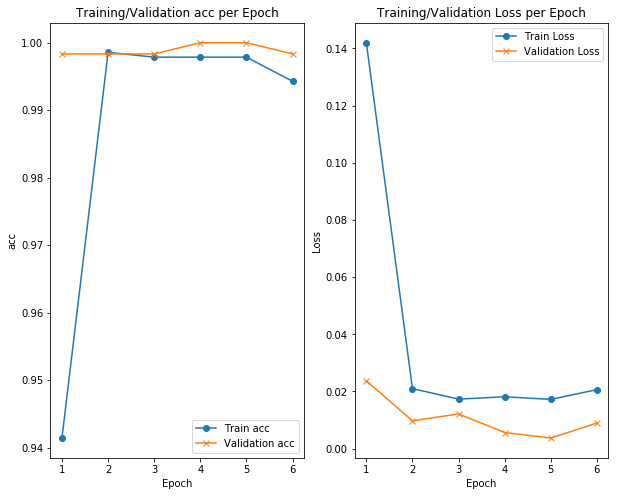

In [12]:
visual_training(history)

## Making Predictions
We proceed to make predictions using the model we've trained. The following cells utilize the global variables inputted before the training of the model above. Below you will find your results.

Workflow for making predictions: Similar as above, except that in this case, the paths to image collections to predict have been established at the beginning of this notebook as: 'fibers_predict', 'nofibers_predict'.

In [13]:
# we prep and randomize the data
equal_fib, equal_nofib = equalize_images(fibers_predict, nofibers_predict)
matrix_pred = create_matrix_shuffle(equal_fib, equal_nofib)

# redefining X and y
cols_pred = len(matrix_pred.columns)-1
X_p = matrix_pred.as_matrix(columns=mat.columns[:cols_pred])
y_p =matrix_pred['Labels']

# one-hot-encode
y_p = to_categorical(y_p)

# making predictions
pred = model.predict(X_p)
pred = (pred > 0.5)

# How did we do?
data_frame, confusion_mat = conf_matrix(y_p, pred)
data_frame

/Users/mirasilvia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


,Measure,Rates
0,Sensitivity,0.990800
1,Specificity,1.000000
2,Precision,1.000000
3,Neg. Pred Rate,0.990884
4,False Pos. Rate,0.000000
5,False Neg. Rate,0.009200
6,False Discovery Rate:,0.000000
7,Accuracy,0.995400


## Conclusion:
Already having high accuracy with a simple Multi Layer Perceptron. 
- We trained with 1400 images, and validated with remaining 600, to get an accuracy of 98% for test data.
- Proceeded to make predicitons with 5000 images, and again we obtained high rate of ~99%. 

**What's next?**
Recreate this notebook with a neater frame work so that you can construct/add layers/alter the architecture in case you want to pass in future data. 
Given that you already have results. Save this but revise and reframe later :)

